In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

2024-03-12 09:06:25.253411: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 09:06:26.645102: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-12 09:06:30.699232: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 09:06:35.599644: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# Load all the data/images into tensorflow
"""
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs
)
"""
IMAGE_SIZE = 256
BATCH_SIZE = 32 # Usually it's a standard, so 32
CHANNELS = 3 # 3 RGB Channels
EPOCHS = 5 # It can be any value, but 50 is appropriate
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    # All images are 256x256 pixels
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset) # 68 as we have total 68 batches with each batch of 32 images

68

2024-03-12 09:06:43.533235: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-03-12 09:06:43.578501: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-03-12 09:06:43.709731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


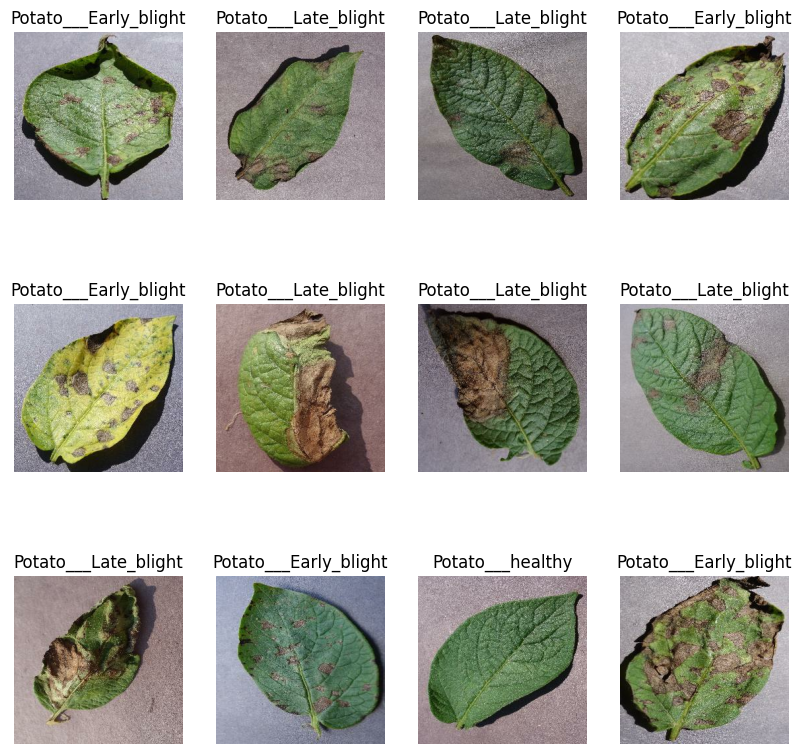

In [6]:
# Increase area for each image being printed to 10x10
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    # Display first 12 images of the first batch of 32 images
    for i in range(12):
        # Make a subplot, like a matrix of images
        ax = plt.subplot(3,4,i+1)
        
        # Everytime we see different image as shuffle=True, so 1st image keeps getting changed
        plt.imshow(image_batch[i].numpy().astype("uint8")) # It is float, so convert to int
    
        # label_batch[0] returns index 0, 1 or 2
        # so we do, class_names[label_batch[0]]
        # class_names: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']
        plt.title(class_names[label_batch[i]]) # Which type of image is this, is it early blight, late blight or healthy
    
        # Remove the axis
        plt.axis("off") 


    
    """
    print(image_batch[0].numpy()) # Convert Tensor to numpy array, it gives a 3d array of the first image at 0th position where each value is between 0 to 255
    print(image_batch[0].shape) # (256, 256, 3)
    
    print(image_batch.shape) # (32, 256, 256, 3) : 32 images, each image is 256,256, 3 is RGB channels
    print(label_batch.numpy()) # Convert tensor to numpy array:
    # [1 1 2 1 1 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1] : 3 classes so, 0 for early blight, 1 for late blight, 2 for healthy
    """

In [7]:
# Spliiting DataSet

"""
80% ==> training
20% ==> 10% validation, 10% testing
We run 50 EPOCHS
1 epoch means: train the model on the 80% data and then at the end of 1 epoch, validate it using 10% validation data
and do this 50 times
once this cycle is completed
test the model using the 10% testing data
"""

'\n80% ==> training\n20% ==> 10% validation, 10% testing\nWe run 50 EPOCHS\n1 epoch means: train the model on the 80% data and then at the end of 1 epoch, validate it using 10% validation data\nand do this 50 times\nonce this cycle is completed\ntest the model using the 10% testing data\n'

In [8]:
# Length of Dataset = 68 batches, where each batch has 32 images
train_size = 0.8 # 80%
len(dataset)*train_size # 80% of 68

54.400000000000006

In [9]:
# Take first 54 batches of data out of 68 and call it train_ds(train data set)
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
# Now skip the first 54 batches out of 68 and get the rest of the data (the remaining 20%)
test_ds = dataset.skip(54) # Similar to slicing in python [54:]
len(test_ds)

14

In [11]:
# Now again split this 20% into 2 parts: 10% validation, 10% testing
val_size = 0.1
len(dataset)*val_size # 10% of my entire data set(68 batches) is 6

6.800000000000001

In [12]:
# Validation Dataset
val_ds = test_ds.take(6) # Take first 6 batches out of the remaining 20% the batches, which is 10% of it
len(val_ds)


6

In [13]:
# Now skip the first 6 batches of the 20% dataset, which gives our 10% test dataset
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
# Function to do all the above data splitting calculations automatically
# Parameters:
"""
ds: dataset
train_split: ratio of training data
val_split: ratio of validation data
test_split: ration of testing data
"""
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    # Size of dataset
    ds_size = len(ds)

    # If shuffle is True then shuffle the dataset
    if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12) # seed is for predictiblity, so if you have same seed everytime, it give you same result everytime, it can be any number (5, 7, ect...)

    # Training Data Size
    # 80% of dataset(ds) and convert to int, so that we don't get float values
    train_size = int(train_split * ds_size)

    # Validation Data Size
    val_size = int(val_split * ds_size)

    # Training Data Set
    # Take the first (train_size) batches out of all the batches of data, where each batch has 32 images
    train_ds = ds.take(train_size)

    # From the remaining 20% of data, take first 10% or (val_size) of data as validation data
    val_ds = ds.skip(train_size).take(val_size)

    # From the reamining 20% data, skip the first 10% or (val_size) of data and use the remaining data as testing data
    test_ds = ds.skip(train_size).skip(val_size)
    
    
    return train_ds, val_ds, test_ds

In [15]:
# Calling function on the dataset
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
# Caching of the training data set
# train_ds.cache(): It will read the image from the memory in the 1st iteration, and when you need the same image, it will keep that image in the memory, so that in every EPOCh we do not need to keep loading it again and again, which improves the performance of the pipeline
# shuffle: will shuffle the images
# prefetch: If we are using GPU and CPU then, if GPU is busy training the data then prefetch will load the next set of batch from the disk and that improves the performance.

# Explaination for : train_ds.cache().shuffle(1000).prefetch()
"""
 (Why use prefectch?)
 Refer Image: CPU_GPU_1
 When loading images, say 32 images at a time and say we have a GPU (eg, Titan RTX)
 When it(GPU) is training, we are not using CPU when GPU is training because CPU is sitting idle
 then when GPU is done, CPU again reads the batch and then GPU is added, so for example in image it takes total 12 seconds

 But when using prefetch and caching : Refer CPU_GPU_2
 While GPU is training batch 1, CPU will be loading next batch(batch 2), that's what prefetch does basically

 (Why use cache?)
 cache on the other hand, refer CACHING_1 image
 In that, in the first row the blue part represents the images being read
 So in the first EPOCH we read images, now again in the 2nd EPOCH same images are being read (Which can be seen in the 2nd blue part)

 But if we use cache(), refere CACHING_2 image
 In this image, we don't see the blue block again, we see it only once
 So by doing that we save time reading those images.
"""
# prefetch(buffer_size=tf.data.AUTOTUNE) : Let tensorflow determine how many batches to load while GPU is training
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Similarly for validation and testing data set
val_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# So far datasets are optimized for training performance, so training will run fast.

In [20]:
# Creating a layer to supply to the final model
resize_and_rescale = tf.keras.Sequential([ # Layers for pre-processing
    # Re-size every image to 256 x 256
    #Question: Images are already 256 x 256, why re-size it ?
    #Ans: This resize_and_rescale layer will eventiually go to the final model that we are creating and when we
    #     have a trained model and when it starts predicting, during prediction if any image that is being supplied to model,
    #     which is not 256 x 256, it will automatically re-size it.
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    
    # It will scale the image to 255
    tf.keras.layers.Rescaling(1.0/255),
])

In [21]:
# Data Augmentation to make the model robust
"""
# Let's say a model is trained based on certain set of images, now when we upload a new image for which we want the prediction
if that image is rotated or is different in contrast then other images in the dataset on which the model is trained
then the model will not perform good.
for that we need data augentation concept.

# What do we do in data augmentation?
# Refer DATA_AUGMENTATION image

Let' says we have an original image in the training data set, using this same image we create 4 new TRAINING samples by applying different transformations to the original image
like horizontal flip, contrast, rotating the image or zooming
Now we will use all these 5 images (1 original + 4 new images) for training the model, which makes the model completely robust

so now, if this model is used in real world, where a rotated image is being supplied to the model, model knows how to predict that.
"""
# Applying random flip and rotation
data_augmentation = tf.keras.Sequential([ # Layers for pre-processing
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

# These layers will be used in the actual model.

In [22]:
# Input Shape
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS) # This is the format of the input
# Number of classes
n_classes = 3

# Building the Convolutional Neural Network (CNN) or Building the model
model = models.Sequential([
    
    # Layer 1: When feed an image, first resize and rescale it
    resize_and_rescale,
    
    # Layer 2: Do the flips and random rotations to generate new samples
    data_augmentation, 
    
    # Layer 3: Convolutional Layer
    # kernel_size is the size of the filters: Refer image FILTER (In image green box is 3x3 filter), so kernel_size is 3x3
    # What's the filter: REFER FILTER_2 image
    # In image we have example of Kola's image detection
    # 1 filter is to detect eye, another to detect nose, and another to detect ears
    # if you have eye, nose, ears of Koala, we can say the image has Koalas head too
    # similarly 1 filter to detect hands and legs, we can conclude that image has Koalas body too
    # if it has both Koals head and body, means it can be a koalas image, so flattern that and kinda figure that out
    # In example, we have 5 layers (eye, nose, ears, hands, legs)

    # For this model, we use 32 layers
    # Why 32 ?
    # Trail and Error, we need a lot of layers where we can detect edges, small features
    # Filter_Size: (3,3)
    # activation = 'relu' as it is fast to compute
    # input_shape: input_shape = (IMAGE_SIZE, IMAGE_SIZE)
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape), 

    # layer 4: Pooling Layer(Like max pooling etc ...): Refer POOLING image
    # Benifit: Preserving the features while reducing the size of the image, which is very helpful computation vise.
    layers.MaxPooling2D((2,2)), 

    # Few extra Convolutional and Pooling layers: (After some trail and error I figured I need to stack a few conv and pooling layers)
    # 32 and 64 are also figured by trial and error method.
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, kernel_size = (3,3), activation='relu'), 
    layers.MaxPooling2D((2,2)),

    # Next refer FILTER_2 image, now we need to flatten it, so it's an array of neurons, so we have a hidden dense layer and then a final output classification layer
    layers.Flatten(),

    # Adding a dense layer of 64 neurons
    layers.Dense(64, activation='relu'),

    # Last layer will have 3 neurons with softmax activation function
    # softmax function normalizes the probablity of the classes
    layers.Dense(n_classes, activation='softmax')
])

# Build the model
model.build(input_shape = input_shape)

# For Layer 3
"""
tf.keras.layers.Conv2D(
    filters,
    kernel_size,
    strides=(1, 1),
    padding='valid',
    data_format=None,
    dilation_rate=(1, 1),
    groups=1,
    activation=None,
    use_bias=True,
    kernel_initializer='glorot_uniform',
    bias_initializer='zeros',
    kernel_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    bias_constraint=None,
    **kwargs
)
"""

/usr/local/python/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


"\ntf.keras.layers.Conv2D(\n    filters,\n    kernel_size,\n    strides=(1, 1),\n    padding='valid',\n    data_format=None,\n    dilation_rate=(1, 1),\n    groups=1,\n    activation=None,\n    use_bias=True,\n    kernel_initializer='glorot_uniform',\n    bias_initializer='zeros',\n    kernel_regularizer=None,\n    bias_regularizer=None,\n    activity_regularizer=None,\n    kernel_constraint=None,\n    bias_constraint=None,\n    **kwargs\n)\n"

In [23]:
# Model Architecture is ready, still training is not done yet

# Model Summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Total params: 183,747 : These are the weights that need to be trained (no.of weights)

# So 1st define the neural network architecture, then compile using optimizers like (adam: it is a famous optimizer), then define loss function, metrics
# Like in each EPOCH, what kind of metric will you use to track the gradient descent
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
# Train the network
# We will record the history of every EPOCH in history parameter to make some plots
history = model.fit(
    train_ds, 
    epochs=EPOCHS, # 50 EPOCHS
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds # During each EPOCH this validation data helps to track the accuracy
)

Epoch 1/5


2024-03-12 09:06:53.997387: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-03-12 09:06:54.023813: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.
2024-03-12 09:06:54.052901: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25165824 exceeds 10% of free system memory.


54/54 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.4629 - loss: 0.9551 - val_accuracy: 0.7008 - val_loss: 0.8375
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.6297 - loss: 0.8379 - val_accuracy: 0.7332 - val_loss: 0.5577
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.7403 - loss: 0.5911 - val_accuracy: 0.8831 - val_loss: 0.3399
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8647 - loss: 0.3414 - val_accuracy: 0.8443 - val_loss: 0.3810
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9029 - loss: 0.2581 - val_accuracy: 0.8958 - val_loss: 0.2586


In [26]:
# Running test on test data set
scores = model.evaluate(test_ds)

54/54 ━━━━━━━━━━━━━━━━━━━━ 31s 581ms/step - accuracy: 0.9056 - loss: 0.2310


In [27]:
scores # Value at 0th position is loss, value at 1st position accuracy

[0.25857311487197876, 0.8958333134651184]

In [28]:
# Let's use history variable
history

In [29]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [37]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [38]:
"""
Sample: The accuracy shown here, is the same accuracy being printed in the result (this is for illustration purpose only)

54/54 ━━━━━━━━━━━━━━━━━━━━ 156s 3s/step - accuracy: 0.4629 - loss: 0.9551 - val_accuracy: 0.7008 - val_loss: 0.8375
Epoch 2/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.6297 - loss: 0.8379 - val_accuracy: 0.7332 - val_loss: 0.5577
Epoch 3/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.7403 - loss: 0.5911 - val_accuracy: 0.8831 - val_loss: 0.3399
Epoch 4/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.8647 - loss: 0.3414 - val_accuracy: 0.8443 - val_loss: 0.3810
Epoch 5/5
54/54 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.9029 - loss: 0.2581 - val_accuracy: 0.8958 - val_loss: 0.2586
"""

history.history['accuracy']

[0.5248842835426331,
 0.6886574029922485,
 0.7662037014961243,
 0.8784722089767456,
 0.8981481194496155]

In [39]:
# Plot training history on matplotlib chart

# Store arrays in variables
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


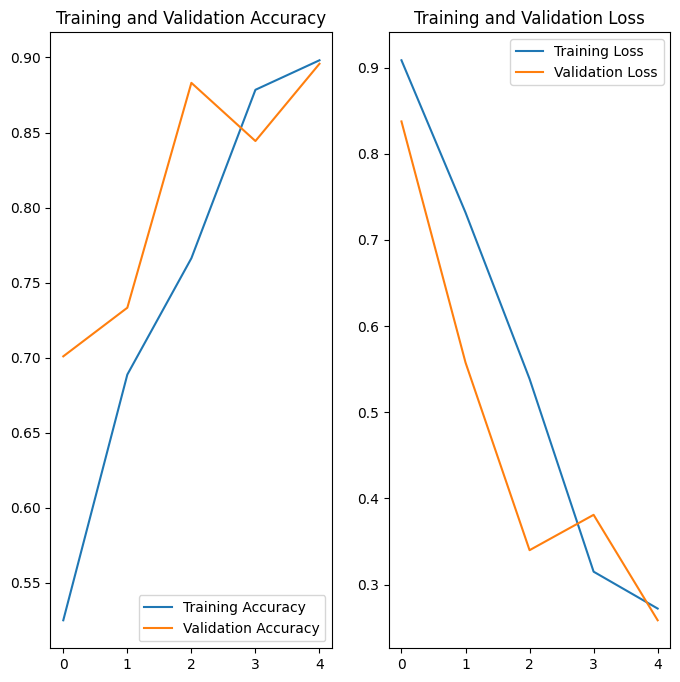

In [41]:
# Plot for Training Accuracy vs Validation Accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot for Training Loss vs Validation Loss
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
Actual Label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Predicted Label: Potato___Early_blight


2024-03-12 10:13:37.414764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


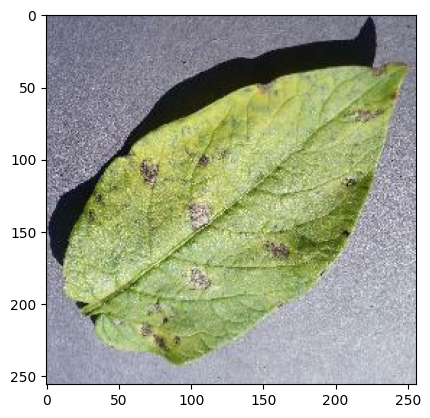

In [48]:
import numpy as np
# Making Predictions
# For now, we take just 1 batch: 32 images
for images_batch, labels_batch in test_ds.take(1):

    # Take 1st image
    # NOTE: Images keeps shuffling, so 1st image will change every time.
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy() # Actual label of the first_image

    # Print the image
    print("first image to predict")
    plt.imshow(first_image)
    # Print the actual label of the image
    print("Actual Label:", class_names[first_label])

    # Prediction
    # model.predict expects image batch
    # batch_prediction is the prediction for all the 32 images in the batch
    batch_prediction = model.predict(image_batch) 
    # To get prediction of the first image 

    # output: [9.9377525e-01 6.2247966e-03 1.4793174e-08]
    # Our model architecture has 3 neurons in output layer, so 3 values and we have used softmax function
    # so these 3 values are 3 probablities and whatever is the highest probablity is our class/answer
    # print(batch_prediction[0]) 

    # Printing predicted label
    print("Predicted Label:", class_names[np.argmax(batch_prediction[0])])

In [49]:
# Function to make the prediction
"""
params:
model: Takes model as the input
img: Takes the image as input for which the prediction is to be made

return:
predicted_class: Class to which image belongs
confidence: With how much confidence does this image belongs to the predicted class/accuracy of prediction
"""
def predict(model, img):
    # Convert image into image array
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    # Create a batch out of it
    img_array = tf.expand_dims(img_array, 0) 

    # Calling predict function
    predictions = model.predict(img_array)

    # find the predicted class
    predicted_class = class_names[np.argmax(predictions[0])]
    # find the confidence
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2024-03-12 10:34:00.298292: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


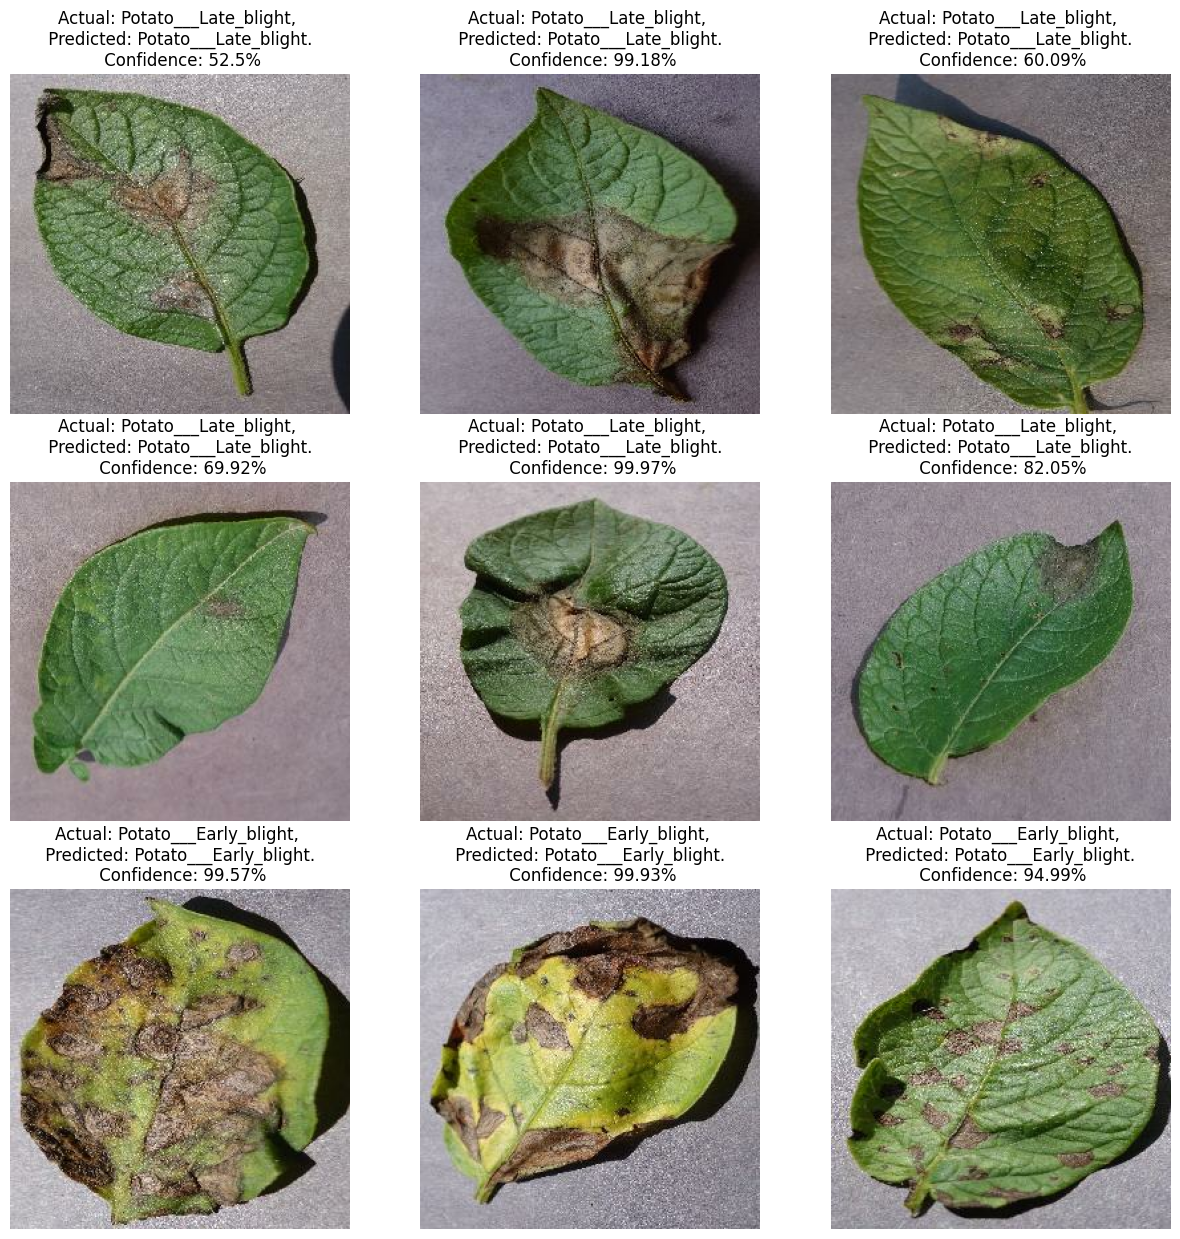

In [50]:
# Enlarge each image being displayed
plt.figure(figsize=(15, 15))
# Predict for a batch
for images, labels in test_ds.take(1):
    # Predict for 9 images not the entire batch
    for i in range(9):
        # Sub-plot to show all 9 images togeather
        ax = plt.subplot(3,3,i + 1)
        # Show the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Predicted Class and Confidence
        predicted_class, confidence = predict(model, images[i].numpy())
        # Actual Class
        actual_class = class_names[labels[i]]

        # Print Preducted Class, Confidence, Actual Class as plot title
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        # Remove the axis
        plt.axis("off")